In [1]:
# ARMA estimation, forcast and order selection
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARMA
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm #A tqdm progress bar shows you how much time has elapsed and the estimated time remaining for the iterable
import sklearn.metrics as skmetrics #For evaluation metrics
from fbprophet import Prophet

import warnings                               
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error
import pmdarima as pm

# FB Prophet Univariate Model

In [2]:
TARGET = 'MedianSoldPrice_AllHomes.California'

In [3]:
train = pd.read_csv('zillow-carlifornia.csv', parse_dates=True).set_index('Date')

Drop NA in train set, since they are in the test set

In [4]:
train = train.dropna(subset = [TARGET], axis = 0)

In [5]:
test = pd.read_csv('test.csv', parse_dates=True).set_index('Month')

In [6]:
train_proph = train.reset_index().rename({TARGET:"y", 'Date':'ds'}, axis = 1)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


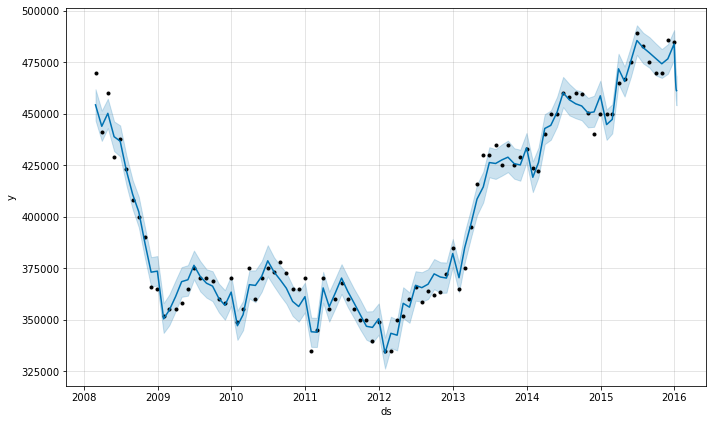

In [7]:
model_1=Prophet()
model_1.fit(train_proph)
future = model_1.make_future_dataframe(periods=len(test))
forecast = model_1.predict(future)
model_1.plot(forecast)
plt.show()

## Calculate Validation Error on training set

In [14]:
def evaluate_prophet_model(X):
    train_size = int(len(X) * 0.75)
    train, test = X.iloc[0:train_size,:], X.iloc[train_size:,:].y # Grab response only for test
    
    predictions = list()
    for t in range(len(test)):
        model = Prophet(weekly_seasonality = False, daily_seasonality = False)
        # breakpoint()
        model.fit(X.iloc[:train_size + t, :])
        future = model.make_future_dataframe(periods=1)
        yhat = np.asanyarray(model.predict(future).iloc[-1,-1]) #predict one step
        predictions.append(yhat) #store prediction
        # calculate out of sample error
    # breakpoint()
    predictions = np.asarray(predictions).reshape(-1,)
    test = np.asanyarray(test).reshape(-1,)
    mae = skmetrics.mean_absolute_error(test, predictions)
    rmse = np.sqrt(skmetrics.mean_squared_error(test, predictions))
    mape = np.mean(np.abs(test-predictions)/test)
    return rmse, mae, mape

In [15]:
rmse_proph, _, _ = evaluate_prophet_model(train_proph)

In [16]:
print(f"CV RMSE of Prophet: {rmse_proph:.2f}")

CV RMSE of Prophet: 11626.61


# Calculate Test Error: Not needed since SARIMA model is final

In [17]:
forecast_test = pd.Series((forecast.iloc[-len(test):,:].yhat.values), index = test.index)

In [18]:
rmse = mean_squared_error(test, forecast_test, squared=False)

In [19]:
print(f"RMSE of Prophet: {rmse:.2f}")

RMSE of Prophet: 38070.81


# SARIMA Model

In [20]:
def adf_test(timeseries):
    #Perform Augmented Dickey-Fuller test:
    print ('Results of Augmented Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [21]:
def diff(data, interval=1):
    diff = list()
    for i in range(interval, len(data)):
        value = data[i] - data[i - interval]
        diff.append(value)
    return diff

In [22]:
def evaluate_sarima_model(X, trend_order, seasonal_order):
    train_size = int(len(X) * 0.75)
    train, test = X[0:train_size], X[train_size:]
    
    predictions = list()
    for t in tqdm(range(len(test))):
        model = sm.tsa.statespace.SARIMAX(X[:train_size+t], order=trend_order,seasonal_order=seasonal_order) #rolling forward for one step at each time
        model_fit = model.fit()
        yhat = np.asanyarray(model_fit.forecast())[0] #predict one step
        predictions.append(yhat) #store prediction
        # calculate out of sample error
    predictions = np.asarray(predictions).reshape(-1,)
    test = np.asanyarray(test).reshape(-1,)
    mae = skmetrics.mean_absolute_error(test, predictions)
    rmse = np.sqrt(skmetrics.mean_squared_error(test, predictions))
    mape = np.mean(np.abs(test-predictions)/test)
    return rmse, mae, mape

## Stationarity
The time series is not stationary

In [23]:
adf_test(train_proph.y)

Results of Augmented Dickey-Fuller Test:
Test Statistic                 -0.058792
p-value                         0.953391
#Lags Used                     12.000000
Number of Observations Used    82.000000
Critical Value (1%)            -3.512738
Critical Value (5%)            -2.897490
Critical Value (10%)           -2.585949
dtype: float64


In [24]:
train_diff = diff(train_proph.y)

In [25]:
adf_test(train_diff)

Results of Augmented Dickey-Fuller Test:
Test Statistic                 -3.088139
p-value                         0.027443
#Lags Used                     11.000000
Number of Observations Used    82.000000
Critical Value (1%)            -3.512738
Critical Value (5%)            -2.897490
Critical Value (10%)           -2.585949
dtype: float64


The time series is stationary after differencing once.

## ACF/PACF

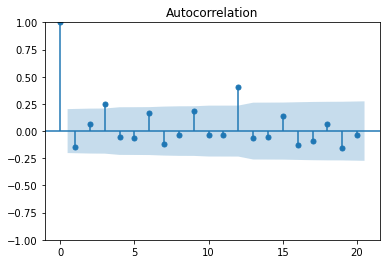

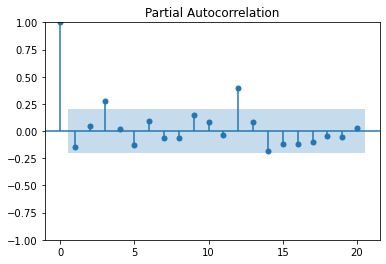

In [26]:
plot_acf(train_diff, lags = 20)
plot_pacf(train_diff, lags = 20)
plt.show()

Appears to be a White Noise process after differencing once.

## Plot Time Series

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


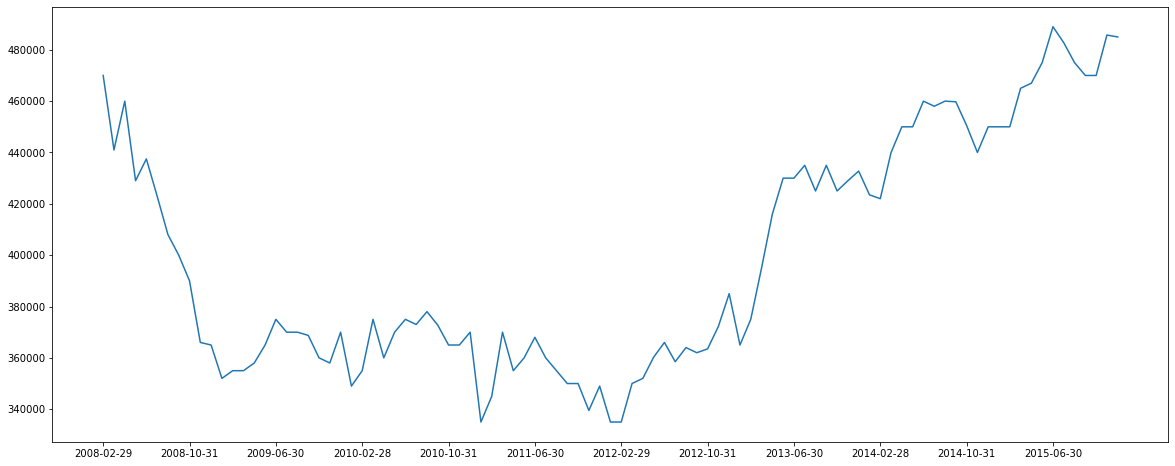

In [27]:
fig, ax = plt.subplots(figsize = (20,8))
ax.plot(train_proph.set_index('ds').y)
ax.set_xticks(np.arange(0,len(train_proph),8))

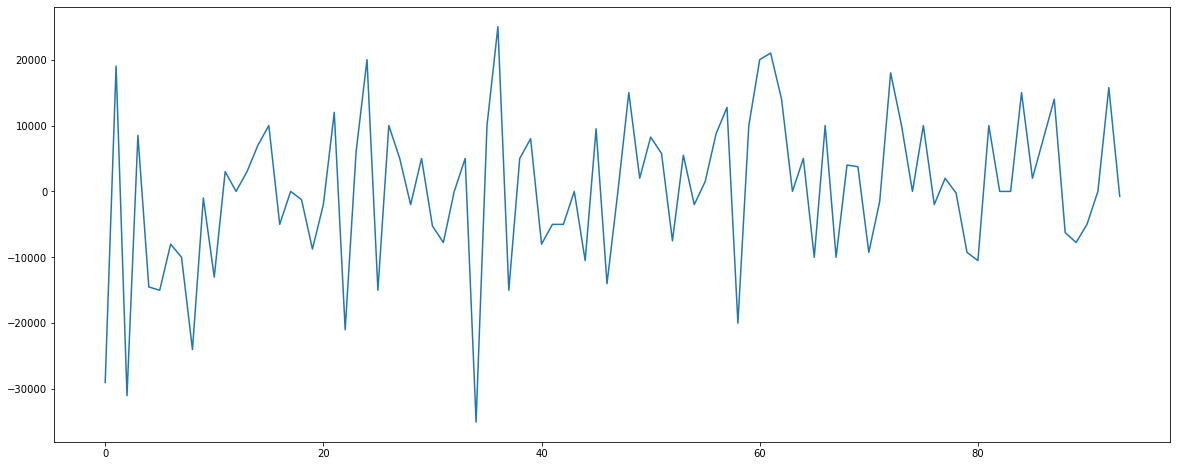

In [28]:
fig, ax = plt.subplots(figsize = (20,8))
ax.plot(train_diff)

In [29]:
model = pm.auto_arima(train_proph.y, start_p=0, start_q=0,
                           max_p=3, max_q=3, m=0,
                           start_P=0, seasonal=False,
                           d=1, D=0, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2028.877, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2022.609, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2023.514, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2026.900, Time=0.00 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2022.030, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=2020.308, Time=0.02 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2021.942, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2020.552, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=2018.530, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=2020.104, Time=0.01 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=2020.121, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2018.655, Time=0.03 sec

Best model:  ARIMA(3,1,0)(0,0,0)[0]          
Total fit time: 0.370 seconds


The best model is an $ARIMA(3,1,0)$

In [30]:
rmse, _, _ =evaluate_sarima_model(train_proph.y,trend_order = (3,1,0), seasonal_order=(0,0,0, 0))

100%|██████████| 24/24 [00:00<00:00, 60.33it/s]


In [31]:
print(f"Cross-Validated RMSE: {rmse:.2f}")

Cross-Validated RMSE: 8810.09


## Decision: Choose $ARIMA(3,1,0)$ as final model

## Calculate Test Error

In [32]:
model = sm.tsa.statespace.SARIMAX(train_proph.y, order=(3,1,0),seasonal_order=(0,0,0,0))
model_fit = model.fit()

In [43]:
forecast_final = model_fit.forecast(len(test))

In [44]:
# Squared = False returns MSE
rmse_final = mean_squared_error(test.values, forecast_final.values, squared = False)

In [45]:
print(f"Test RMSE: {rmse_final:.2f}")

Test RMSE: 21702.05


## Plot forecast

In [46]:
forecast_final = pd.Series(forecast_final.values, index = test.index)

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

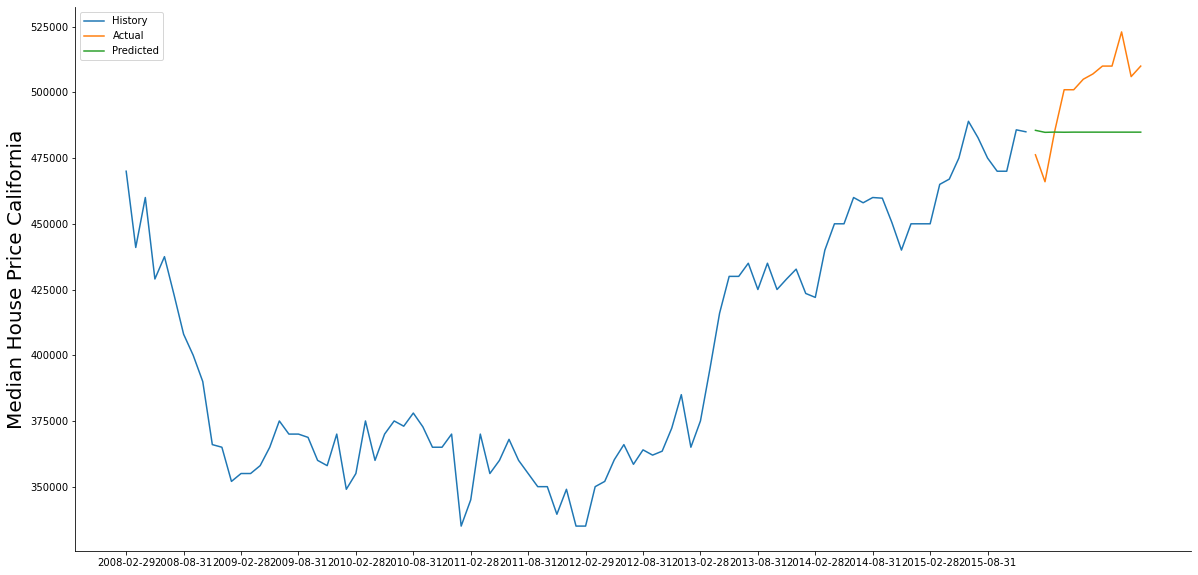

In [53]:
fig, ax = plt.subplots(figsize = (20,10))
ax.plot(train_proph.set_index('ds').y, label = 'History')
ax.plot(test, label = 'Actual')
ax.plot(forecast_final, label = 'Predicted')
ax.set_xticks(np.arange(0,len(train_proph),6))
ax.legend()
ax.set_ylabel('Median House Price California', fontsize = 20)
for pos in ['top','right']:
    ax.spines[pos].set_visible(False)